In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from itertools import islice
import nengo

import pytry

First, we just read the raw data file.  We drop any rows that have N/A data in them.

In [2]:
data = pd.read_csv("annotateddata.csv", low_memory=False)

x = np.array(data.iloc[:,11:195]).astype(float) #array of data for purple child (points in space for each frame)
labs = np.array(data.iloc[:,443]).astype(str) #array of labels (purple child annotations, engagement) 218/443
a = []
for i in range(x.shape[1]):
    y = pd.Series(x[:,i])
    if i == 180:               # add these three lines
        y[y>0]-=np.pi*2   # add these three lines
        y += np.pi            # add these three lines
    z = y.interpolate(limit_direction='both')
    a.append(z)
a = pd.DataFrame(a)
a = a.dropna()
a = np.array(a).T

In [3]:
n_dims=2 
seed=1

dt = 0.001
target_dt = 1.0/30
D = n_dims # param.n_dims
classify_score = {}
accuracy = {}

Here's a helper function to take a window of that data, extract it out, and resample it to a given dt using interpolation.

In [4]:
def extract_pattern(start, end, target_dt): #function to extract consecutive frames with the same label 
    pattern = np.array(a[start:end,:]).astype(float)
    frames = np.array(data.iloc[start:end,9]).astype(int)
    timestamp = np.array(data.iloc[start:end,0]).astype(str)

    good_indices = frames != -1
    frames = frames[good_indices]
    pattern = pattern[good_indices]

    fps = 30.0
    t_sample = (frames - frames[0])/fps

    t = np.arange(int(t_sample[-1]/target_dt))*target_dt

    result = []
    for i in range(pattern.shape[1]):       
        p = np.interp(t, t_sample, pattern[:,i])
        result.append(p)
    result = np.array(result).T

    return timestamp, result

Now we find the slices of data that correspond to different labelled events

In [5]:
start=[]
start.append(0)
end=[]
label = []
for i in range(1, (len(labs)-1)):
    if labs[i]!=labs[i-1]:
        start.append(i)
    if labs[i]!=labs[i+1]:
        end.append(i)
        label.append(labs[i])

And then extract all that data out.  Notice that we're extracting it out with a dt of 1/30s, since that's about what the data is stored at.  This means we're not generating huge datasets.

In [6]:
t_noplay=[]
p_noplay=[]
t_goal=[]
p_goal=[]
t_aim=[]
p_aim=[]

for i in range(1,(len(start)-1)):
    try:
        if label[i]==('noplay'):
            ts, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_noplay.append(ts)
            p_noplay.append(pi)
        if label[i]==('goaloriented'):
            ts, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_goal.append(ts)
            p_goal.append(pi)
        if label[i]==('aimless'):
            ts, pi = extract_pattern(start[i], end[i], target_dt=target_dt)
            t_aim.append(ts)
            p_aim.append(pi)
    except IndexError:
        print('empty pattern')


empty pattern
empty pattern
empty pattern
empty pattern
empty pattern


Now we collect all that data together and define training and test sets.

In [7]:
i=0
goal = []
noplay = []
aim = []
for entry in t_goal:
    goal.append([t_goal[i],p_goal[i]])
    i = i+1
i=0
for entry in t_noplay:
    noplay.append([t_noplay[i],p_noplay[i]])
    i = i+1
i=0
for entry in t_aim:
    aim.append([t_aim[i],p_aim[i]])
    i = i+1

p_goal2 = random.sample(goal, len(goal))
p_noplay2 = random.sample(noplay, len(noplay))
p_aim2 = random.sample(aim, len(aim))

In [8]:
############ randomly split data 80/20 into training and testing sets ############ 
goal_train_ts = np.array(p_goal2[:(int(len(p_goal2)*0.8))]) 
goal_test_ts = np.array(p_goal2[(int(len(p_goal2)*0.8)):]) 
goal_train_list=list(goal_train_ts[:,1])
goal_test_list=list(goal_test_ts[:,1])
goal_train_time=list(goal_train_ts[:,0])
goal_test_time=list(goal_test_ts[:,0])

noplay_train_ts = np.array(p_noplay2[:(int(len(p_noplay2)*0.8))]) 
noplay_test_ts = np.array(p_noplay2[(int(len(p_noplay2)*0.8)):]) 
noplay_train_list=list(noplay_train_ts[:,1])
noplay_test_list=list(noplay_test_ts[:,1])
noplay_train_time=list(noplay_train_ts[:,0])
noplay_test_time=list(noplay_test_ts[:,0])


In [11]:
for p in noplay_train_list:
    if p.size > 0:
        pass
    else:
        noplay_train_list.remove(p)
        
for p in noplay_test_list:
    if p.size >0:
        pass
    else:
        noplay_test_list.remove(p)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """


Do the PCA (just on the training data)

In [12]:
train_all = np.vstack(goal_train_list+noplay_train_list)
pca_model = PCA(n_components=D).fit(train_all)

train_time_all = np.hstack(goal_train_time+noplay_train_time)
test_time_all = np.hstack(goal_test_time+noplay_test_time)

goal_train_pca = np.vstack([pca_model.transform(p) for p in goal_train_list])
noplay_train_pca = np.vstack([pca_model.transform(p) for p in noplay_train_list])
goal_test_pca = np.vstack([pca_model.transform(p) for p in goal_test_list])
noplay_test_pca = np.vstack([pca_model.transform(p) for p in noplay_test_list])

For speed reasons, we can control how much of the training and testing data to use

In [13]:
print(len(goal_train_pca))
print(len(noplay_test_pca))

588638
41407


In [14]:
len_train = 500 #int(len(noplay_train_pca)/30)
T_train = len_train #param.len_train   # number of seconds to train on for each class
T_test = 100 #len of noplay test 67    # number of seconds to test on for each class

print('Length of Training Pattern for each pattern type: ', len_train)
print('Length of Testing Pattern for each pattern type: ', T_test)

goal_train_time2 = [item for sublist in goal_train_time for item in sublist]
noplay_train_time2 = [item for sublist in noplay_train_time for item in sublist]

goal_test_time2 = [item for sublist in goal_test_time for item in sublist]
noplay_test_time2 = [item for sublist in noplay_test_time for item in sublist]

Length of Training Pattern for each pattern type:  500
Length of Testing Pattern for each pattern type:  100


Let's take a look at the training data

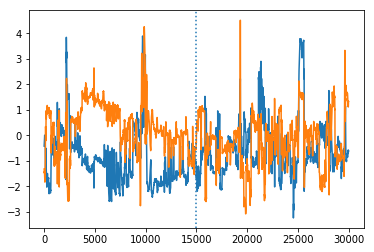

In [15]:
N_frames = int(T_train*30)
training = np.vstack([goal_train_pca[:N_frames], noplay_train_pca[:N_frames]])
train_timestamps = np.hstack([goal_train_time2[:N_frames], noplay_train_time2[:N_frames]])
assert len(training) == N_frames*2

N_frames = int(T_test*30)
testing = np.vstack([goal_test_pca[:N_frames], noplay_test_pca[:N_frames]])
test_timestamps = np.hstack([goal_test_time2[:N_frames], noplay_test_time2[:N_frames]])
assert len(testing) == N_frames*2

plt.plot(training)
plt.axvline(int(len(training)/2), ls=':')

Feed the training data into the network and record what information would be fed into the pool.

In [16]:
############ TRAINING WITH 80% ############ 
num_epochs = 1 
batch_size = int(T_train*30)
batch = 0
theta = 15

for epoch in range(num_epochs):
    training = np.vstack([goal_train_pca[batch:int(batch+batch_size)], noplay_train_pca[batch:int(batch+batch_size)]])
    batch += batch_size
    
    net = nengo.Network(seed=seed)#param.seed)
    with net:
        rw = []
        for i in range(D):
            process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                       presentation_time=1.0/30)
            rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                      process=process, 
                                                      neuron_type=nengo.Direct()))


        node_pool = nengo.Node(None, size_in=rw[0].state.size_out*D)

        start = 0
        for r in rw:
            nengo.Connection(r.state, node_pool[start:start+r.state.size_out])
            start += r.state.size_out



        stim = nengo.Node(nengo.processes.PresentInput(training, presentation_time=1.0/30))
        assert stim.size_out == D
        for i in range(D):
            nengo.Connection(stim[i], rw[i].input, synapse=None)

        p_node_pool = nengo.Probe(node_pool, sample_every = 0.1)


    sim = nengo.Simulator(net)
    with sim:
        sim.run(T_train*2)  
                
        
    pool_model = nengo.Network()
    with pool_model:
        pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                              neuron_type=nengo.LIFRate(), seed=seed)
    pool_sim = nengo.Simulator(pool_model)

    import nengo.utils.ensemble

    _, a = nengo.utils.ensemble.tuning_curves(pool, pool_sim, inputs=sim.data[p_node_pool])
                                       
    if epoch == 0:
        a_goal = a[:(int(len(a)/2))]
        a_noplay = a[(int(len(a)/2)):]
    else:
        a_goal = np.concatenate((a_goal, a[:(int(len(a)/2))]))
        a_noplay = np.concatenate((a_noplay, a[(int(len(a)/2)):]))
    
a_out = np.vstack([a_goal, a_noplay])

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

And let's compute a decoder

In [17]:
N = int((len(a_out))/2) #int(T_train*1000)
target = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)
dec, info = nengo.solvers.LstsqL2(reg=0.1)(a_out, target)

How well does that decoder do?   We could compute rmse, but instead of that let's do classification accuracy.

Text(0.5,1,'training classification accuracy: 97.24%')

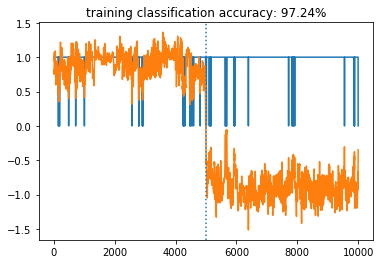

In [18]:
v = np.dot(a_out, dec)
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score_train = np.mean(classify)

classify_score[0]=score_train

accuracy = dict(islice(enumerate(v), None, None, 100)) 
accuracy_train={}
for i in range(len(accuracy)):
    accuracy_train[i]=accuracy[i*100]

for j in range(len(accuracy_train)):      
    key_j = 'accuracy_train{}'.format("%04d" % j)  
    accuracy_train[key_j] = accuracy_train.pop(j)      

plt.plot(classify)
plt.plot(v)
plt.axvline(int(len(classify)/2), ls=':')
plt.title('training classification accuracy: %1.2f%%' % (score_train*100))

In [19]:
'''data = pd.DataFrame(output_train)
data = pd.DataFrame(data.iloc[0::2])
data = data.reset_index(drop=True)
data'''


'data = pd.DataFrame(output_train)\ndata = pd.DataFrame(data.iloc[0::2])\ndata = data.reset_index(drop=True)\ndata'

(array([   5.,   68.,  503., 1537., 1702.,  780.,  267.,   96.,   20.,
          22.]),
 array([-1.5146246 , -1.36860438, -1.22258417, -1.07656395, -0.93054374,
        -0.78452353, -0.63850331, -0.4924831 , -0.34646288, -0.20044267,
        -0.05442246]),
 <a list of 10 Patch objects>)

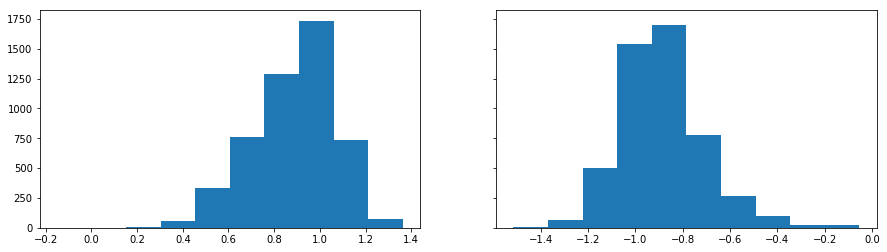

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
ax1.hist(v[:N], label='goal training')
ax2.hist(v[N:], label='noplay training')

Now let's run it on the test set.  We combine the rolling window, the pool, and the decoder into one model.

In [21]:
############ TESTING WITH 20% ############ 
test_net = nengo.Network(seed=seed)#param.seed)
with test_net:
    rw = []
    for i in range(D):
        process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                   presentation_time=1.0/30)
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.Direct()))


    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=seed)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out



    stim = nengo.Node(nengo.processes.PresentInput(testing, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)

    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

    p_test_result_sample = nengo.Probe(result, sample_every = 0.1)


test_sim = nengo.Simulator(test_net)
test_sim.run(T_test*2)    

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 25.55%')

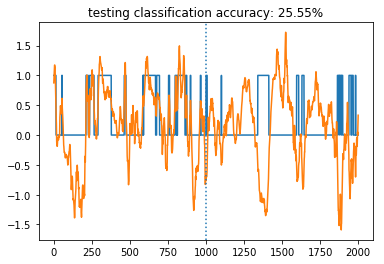

In [22]:
N = int(T_test*10)

v = test_sim.data[p_test_result_sample]
classify1 = np.isclose(v[:N], 1, atol=0.5)
classify2 = np.isclose(v[N:], -1, atol=0.5)
classify = np.append(classify1, classify2)
score_test = np.mean(classify)

classify_score[1]=score_test
    
plt.plot(classify)
plt.plot(v)
plt.axvline(int(len(classify)/2), ls=':')
plt.title('testing classification accuracy: %1.2f%%' % (score_test*100))

(array([ 29.,  58.,  67.,  89., 183., 232., 190., 116.,  27.,   9.]),
 array([-1.59091043, -1.25944621, -0.92798199, -0.59651777, -0.26505355,
         0.06641067,  0.39787489,  0.72933911,  1.06080333,  1.39226755,
         1.72373177]),
 <a list of 10 Patch objects>)

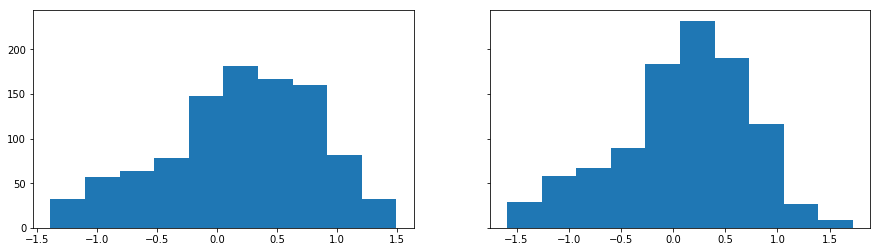

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 4))
ax1.hist(v[:N], label='goal testing')
ax2.hist(v[N:], label='noplay testing')

Now we test on the aimless patterns where the output should be around 0.

In [24]:
############ TESTING WITH AIMLESS PATTERNS ############ 
#p_aim = random.sample(p_aim, len(p_aim))

#aim_train_pca = np.vstack([pca_model.transform(p) for p in p_aim])

#A_len = int(len(aim_train_pca)/30) #Testing on full aimless data
#print(A_len)

#N_frames = T_test*30

#test_aim = np.vstack([aim_train_pca[:N_frames]])
#assert len(test_aim) == N_frames

aim_list=list(p_aim2[:,1])
aim_time=list(p_aim2[:,0])
aim_time_all = np.hstack(aim_time)

aim_train_pca = np.vstack([pca_model.transform(p) for p in aim_list])
aim_time2 = [item for sublist in aim_time_all for item in sublist]

N_frames = T_test*30
test_aim = np.vstack([aim_train_pca[:N_frames]])
assert len(test_aim) == N_frames

aim_timestamps = np.hstack([aim_time2[:N_frames]])

5724


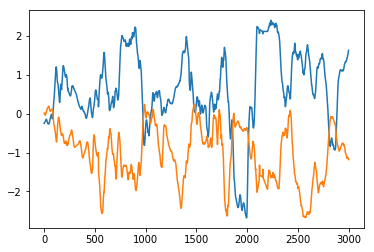

In [25]:
plt.plot(test_aim)

In [30]:
aim_test_net = nengo.Network(seed=seed)#param.seed)
with aim_test_net:
    rw = []
    for i in range(D):
        process = nengo.processes.PresentInput(np.hstack([goal_train_pca[:,i], noplay_train_pca[:,i]]), 
                                                   presentation_time=1.0/30)
        rw.append(nengolib.networks.RollingWindow(theta=theta, n_neurons=3000, 
                                                  process=process, 
                                                  neuron_type=nengo.Direct()))


    pool = nengo.Ensemble(n_neurons=3000, dimensions=node_pool.size_out,
                          neuron_type=nengo.LIFRate(), seed=seed)

    start = 0
    for r in rw:
        nengo.Connection(r.state, pool[start:start+r.state.size_out])
        start += r.state.size_out



    stim = nengo.Node(nengo.processes.PresentInput(test_aim, presentation_time=1.0/30))
    assert stim.size_out == D
    for i in range(D):
        nengo.Connection(stim[i], rw[i].input, synapse=None)

    p_stim = nengo.Probe(stim)

    result = nengo.Node(None, size_in=1)
    nengo.Connection(pool.neurons, result, transform=dec.T, synapse=None)

    p_aim_result_sample = nengo.Probe(result, sample_every=0.1)


aim_test_sim = nengo.Simulator(aim_test_net)
aim_test_sim.run(T_test)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Text(0.5,1,'testing classification accuracy: 41.00%')

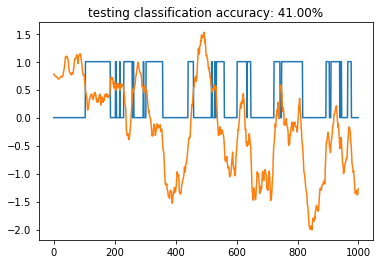

In [31]:
v = aim_test_sim.data[p_aim_result_sample]
classify = np.isclose(v, 0, atol=0.5)
score_aim = np.mean(classify)

classify_score[2]=score_aim
    
plt.plot(classify)
plt.plot(v)
plt.title('testing classification accuracy: %1.2f%%' % (score_aim*100))

(array([ 28.,  78., 129.,  77., 129., 134., 151., 174.,  77.,  23.]),
 array([-2.00587241, -1.65271692, -1.29956143, -0.94640594, -0.59325045,
        -0.24009495,  0.11306054,  0.46621603,  0.81937152,  1.17252701,
         1.52568251]),
 <a list of 10 Patch objects>)

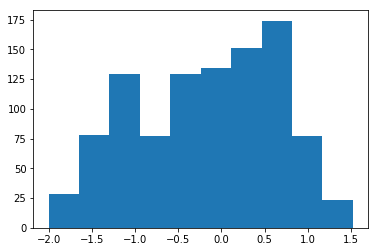

In [32]:
plt.hist(v, label='aimless testing')

In [ ]:
aim_timestamps2 = aim_timestamps[0::3]

output_aim = {}
for i in range(len(v)):
    output_aim[i]={"time":aim_timestamps[i], "out_aim":v[i]}

for j in range(len(output_aim)):        
    key_j = 'output_aim{}'.format("%04d" % j)  
    output_aim[key_j] = output_aim.pop(j) 

In [ ]:
accuracy = dict(islice(enumerate(v), None, None, 100)) 
accuracy_train={}
for  in range(len(accuracy)):
    accuracy_train[i]=accuracy[i*100]
    


for j in range(len(accuracy_train)):        
    key_j = 'accuracy_train{}'.format("%04d" % j)  
    accuracy_train[key_j] = accuracy_train.pop(j)  